In [133]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch import nn
import torch.optim as optim
import random
import warnings

def set_seed(seed=42):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)          

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False     

set_seed(42)


print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [134]:
df = pd.read_csv("creditcard.csv")
df = df.drop(columns=['Time'])
df['Class'].value_counts(normalize=False)

Class
0    284315
1       492
Name: count, dtype: int64

Here, time is the number of seconds elapsed a particular transaction from the first transaction.  
All the "V" features are anonymized with PCA to make sure no banking details of the customers get leaked. Those features are previously the banking details.  
PCA -> Principal components  
It’s like scrambling the columns, but in a very smart way that retains the structure, patterns, and most meaningful variation.  
Note : The new axes are uncorrelated.  
Here, the amount column is transaction amount  
Class :- 1 for fraudulent, 0 otherwise.

There are only 492 fraudulent transactions in 284807 total transcations.

In [135]:
percentage = (492/283807) * 100
percentage

0.17335724629766003

>So, roughly 0.173 percentage of the overall transcations are fraudulent.

>That means, the model is gonna give 99.83 % accuracy regardless but that won't be useful as it's gonna miss the fraudluent transactions.

>The aim of this project won't be to acquire a better accuracy but it will rely more on precision, recall and, F1 score.

### Working with data

In [136]:
X = df.iloc[ :, 0:-1]
y = df.iloc[ :, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train['Amount_scaled'] = scaler.fit_transform(X_train[['Amount']])
X_train = X_train.drop(columns=["Amount"]).values

X_test['Amount_scaled'] = scaler.transform(X_test[['Amount']])
X_test = X_test.drop(columns=["Amount"]).values

smote = SMOTE(random_state = 42)
X_train, y_train, = smote.fit_resample(X_train, y_train)

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Converting training features into float tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Converting labels into float tensors
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [138]:
X_train.shape[1]

29

### Models

In [139]:
class Modelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(29, 64)
        self.relu = nn.ReLU()

        self.layer_2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()

        self.layer_3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu2(self.layer_2(x))
        x = self.sigmoid(self.layer_3(x))
        return x

In [140]:
model = Modelv1()
model.to(device)

Modelv1(
  (layer_1): Linear(in_features=29, out_features=64, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [141]:
with torch.inference_mode():
    y_pred = model(X_train)
    y_labels = torch.round(y_pred)

print("Confusion matrix: \n", confusion_matrix(y_train.cpu(), y_labels.cpu()), "\n")
print("accuracy_score : ", round((accuracy_score(y_train.cpu(), y_labels.cpu()) * 100), 2), "%")

Confusion matrix: 
 [[227445      6]
 [227451      0]] 

accuracy_score :  50.0 %


In [142]:
loss_fn = nn.BCELoss()

Adam_optim = optim.Adam(model.parameters(), lr = 0.0005)
optimizer = Adam_optim

In [143]:
patience = 10
best_f1 = 0
epochs_no_improve = 0
early_stop = False
best_thresh = 0.5 

epoch_count = []
test_loss_vals = []
train_loss_vals = []
test_accuracies = []
roc_scores = []
recall_scores = []
f1_scores = []
precision_scores = []
thresholds_used = []

epochs = 100

for epoch in range(epochs):
    if early_stop:
        print(f"\nEarly stopping at epoch {epoch}")
        break

    model.train()
    y_pred_train = model(X_train)
    loss = loss_fn(y_pred_train, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred_probs = model(X_test)
        y_probs = test_pred_probs.cpu().numpy().flatten()
        y_true = y_test.cpu().numpy()

        # Threshold tuning to find the optiaml threshold
        thresholds = np.arange(0.1, 0.91, 0.01)
        best_epoch_f1 = 0
        best_epoch_thresh = 0.5
        for t in thresholds:
            y_pred_temp = (y_probs >= t).astype(int)
            f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
            if f1_temp > best_epoch_f1:
                best_epoch_f1 = f1_temp
                best_epoch_thresh = t

        # Applying the best threshold for the particular epoch
        y_pred = (y_probs >= best_epoch_thresh).astype(int)

        test_loss = loss_fn(test_pred_probs, y_test)
        test_accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_score = roc_auc_score(y_true, y_probs)

        epoch_count.append(epoch)
        test_loss_vals.append(test_loss.item())
        train_loss_vals.append(loss.item())
        test_accuracies.append(test_accuracy)
        roc_scores.append(roc_score)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)
        thresholds_used.append(best_epoch_thresh)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = best_epoch_thresh
            epochs_no_improve = 0
            torch.save({
                'model_state': model.state_dict(),
                'best_threshold': best_thresh,
                'epoch': epoch,
                'f1_score': f1,
                'roc_score' : roc_score,
                'precision' : precision,
                'recall_score' : recall,
            }, 'best_model_with_threshold.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
        
        if epoch % 3 == 0:
            print(f"Epoch : {epoch} | Threshold : {best_epoch_thresh:.2f} | Train Loss : {loss:.4f} | Test Loss : {test_loss:.4f} | "
                f"Accuracy : {test_accuracy:.4f} | ROC AUC : {roc_score:.4f} | Recall : {recall:.4f} | "
                f"F1 : {f1:.4f} | Precision : {precision:.4f}")


Epoch : 0 | Threshold : 0.19 | Train Loss : 0.8406 | Test Loss : 0.5883 | Accuracy : 0.0019 | ROC AUC : 0.0981 | Recall : 1.0000 | F1 : 0.0034 | Precision : 0.0017
Epoch : 3 | Threshold : 0.49 | Train Loss : 0.7595 | Test Loss : 0.5956 | Accuracy : 0.9960 | ROC AUC : 0.2443 | Recall : 0.0306 | F1 : 0.0260 | Precision : 0.0226
Epoch : 6 | Threshold : 0.50 | Train Loss : 0.6946 | Test Loss : 0.6013 | Accuracy : 0.9976 | ROC AUC : 0.7367 | Recall : 0.2245 | F1 : 0.2458 | Precision : 0.2716
Epoch : 9 | Threshold : 0.52 | Train Loss : 0.6431 | Test Loss : 0.6050 | Accuracy : 0.9987 | ROC AUC : 0.9236 | Recall : 0.4592 | F1 : 0.5455 | Precision : 0.6716
Epoch : 12 | Threshold : 0.54 | Train Loss : 0.6025 | Test Loss : 0.6064 | Accuracy : 0.9990 | ROC AUC : 0.9507 | Recall : 0.5816 | F1 : 0.6628 | Precision : 0.7703
Epoch : 15 | Threshold : 0.56 | Train Loss : 0.5695 | Test Loss : 0.6053 | Accuracy : 0.9991 | ROC AUC : 0.9614 | Recall : 0.6531 | F1 : 0.7111 | Precision : 0.7805
Epoch : 18 | T

48th epoch looks the best with highest f1 score and precision also having high ROC AUC and recall.

In [144]:
checkpoint = torch.load('best_model_with_threshold.pt')
model.load_state_dict(checkpoint['model_state'])
best_thresh = checkpoint['best_threshold']

print(f"Model from epoch {checkpoint['epoch']} with Best Thereshold: {checkpoint['best_threshold']:.4f} | F1 = {checkpoint['f1_score']:.4f} | Precision : {checkpoint['precision']:.4f} | AUC : {checkpoint['roc_score']:.4f} | Recall : {checkpoint['recall_score']:.4f}")

Model from epoch 48 with Best Thereshold: 0.6800 | F1 = 0.8229 | Precision : 0.8404 | AUC : 0.9720 | Recall : 0.8061


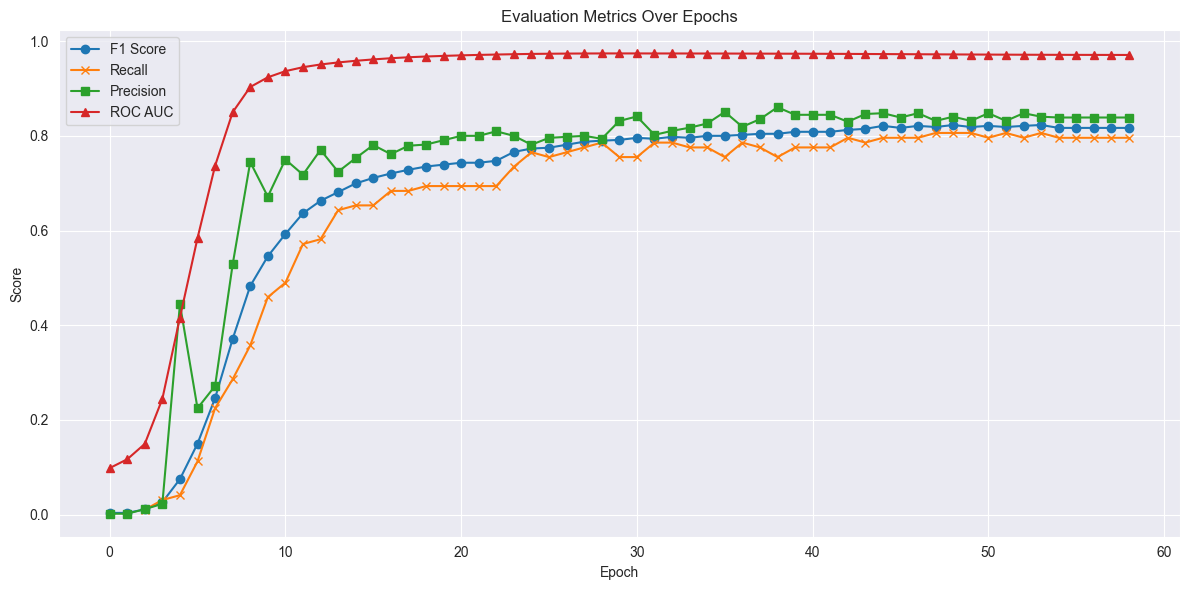

In [145]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(epoch_count, f1_scores, label='F1 Score', marker='o')
plt.plot(epoch_count[2:], recall_scores[2:], label='Recall', marker='x')
plt.plot(epoch_count, precision_scores, label='Precision', marker='s')
plt.plot(epoch_count, roc_scores, label='ROC AUC', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


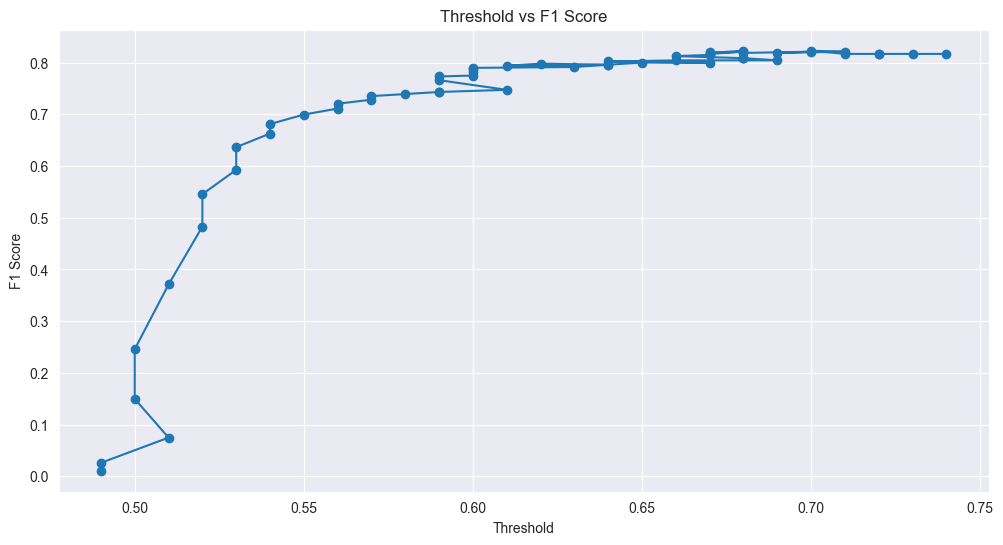

In [146]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(thresholds_used[2:], f1_scores[2:], marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.show()

In [147]:
with torch.inference_mode():
    test_probs = model(X_test).cpu().numpy().flatten()
    final_preds = (test_probs >= best_thresh).astype(int)
    y_true = y_test.cpu().numpy()

conf_matrix = confusion_matrix(y_true, final_preds)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[56849    15]
 [   19    79]]
